# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi wikipedia. 
Outline of the exercise:
* Dataset preparation
* Preprocessing (25 Points) 
* Exploration (20 Points) 
* TF-IDF + Search (55 Points)

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Section 0: Please enter your name below
# Name: SEYED MOSTAFA ALAVI
# Student Number: 401211363



# Section 1: Dataset preparation

This section of notebook contains only shell commands. You don't need to completely understand each command or change anything.

Please run all the paragraphs sequentially.

In [1]:
! sudo apt-get -y install wget git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.13).
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


## Download the dump

In [1]:
! wget --no-check-certificate -P . https://dumps.wikimedia.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2

--2022-11-17 23:26:24--  https://dumps.wikimedia.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.142, 2620:0:861:2:208:80:154:142
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114458404 (1.0G) [application/octet-stream]
Saving to: ‘./fawiki-latest-pages-articles-multistream.xml.bz2’

fawiki-latest-pages 100%[===================>]   1.04G  3.65MB/s    in 4m 23s  

2022-11-17 23:30:49 (4.04 MB/s) - ‘./fawiki-latest-pages-articles-multistream.xml.bz2’ saved [1114458404/1114458404]



## Extract the dump (this may take a few minutes)

In [2]:
! bzip2 -d fawiki-latest-pages-articles-multistream.xml.bz2

## Clone git project for converting wikipedia xml dump to json

In [7]:
! pip install wikiextractor

Defaulting to user installation because normal site-packages is not writeable


## Run the script to convert xml to json (this might take around 30 minutes)

In [9]:
! python3 -m wikiextractor.WikiExtractor --json fawiki-latest-pages-articles-multistream.xml

INFO: Preprocessing 'fawiki-latest-pages-articles-multistream.xml' to collect template definitions: this may take some time.
INFO: Preprocessed 100000 pages
INFO: Preprocessed 200000 pages
INFO: Preprocessed 300000 pages
INFO: Preprocessed 400000 pages
INFO: Preprocessed 500000 pages
INFO: Preprocessed 600000 pages
INFO: Preprocessed 700000 pages
INFO: Preprocessed 800000 pages
INFO: Preprocessed 900000 pages
INFO: Preprocessed 1000000 pages
INFO: Preprocessed 1100000 pages
INFO: Preprocessed 1200000 pages
INFO: Preprocessed 1300000 pages
INFO: Preprocessed 1400000 pages
INFO: Preprocessed 1500000 pages
INFO: Preprocessed 1600000 pages
INFO: Preprocessed 1700000 pages
INFO: Preprocessed 1800000 pages
INFO: Preprocessed 1900000 pages
INFO: Preprocessed 2000000 pages
INFO: Preprocessed 2100000 pages
INFO: Preprocessed 2200000 pages
INFO: Preprocessed 2300000 pages
INFO: Preprocessed 2400000 pages
INFO: Preprocessed 2500000 pages
INFO: Preprocessed 2600000 pages
INFO: Preprocessed 2700000

## Ensure output files exist

In [10]:
! ls text/*/*

text/AA/wiki_00  text/AI/wiki_60  text/AR/wiki_20  text/AZ/wiki_80
text/AA/wiki_01  text/AI/wiki_61  text/AR/wiki_21  text/AZ/wiki_81
text/AA/wiki_02  text/AI/wiki_62  text/AR/wiki_22  text/AZ/wiki_82
text/AA/wiki_03  text/AI/wiki_63  text/AR/wiki_23  text/AZ/wiki_83
text/AA/wiki_04  text/AI/wiki_64  text/AR/wiki_24  text/AZ/wiki_84
text/AA/wiki_05  text/AI/wiki_65  text/AR/wiki_25  text/AZ/wiki_85
text/AA/wiki_06  text/AI/wiki_66  text/AR/wiki_26  text/AZ/wiki_86
text/AA/wiki_07  text/AI/wiki_67  text/AR/wiki_27  text/AZ/wiki_87
text/AA/wiki_08  text/AI/wiki_68  text/AR/wiki_28  text/AZ/wiki_88
text/AA/wiki_09  text/AI/wiki_69  text/AR/wiki_29  text/AZ/wiki_89
text/AA/wiki_10  text/AI/wiki_70  text/AR/wiki_30  text/AZ/wiki_90
text/AA/wiki_11  text/AI/wiki_71  text/AR/wiki_31  text/AZ/wiki_91
text/AA/wiki_12  text/AI/wiki_72  text/AR/wiki_32  text/AZ/wiki_92
text/AA/wiki_13  text/AI/wiki_73  text/AR/wiki_33  text/AZ/wiki_93
text/AA/wiki_14  text/AI/wiki_74  text/AR/wiki_34  text/AZ/wik

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [ ]:
#! pip install pyspark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("MDA_2021") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

22/12/06 07:00:06 WARN Utils: Your hostname, mostafa-UX410UQK resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface wlp2s0)
22/12/06 07:00:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 07:00:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading the data

In [2]:
articles_rdd = sc.textFile("text/*/*") # Now you have a RDD with wikipedia posts

## RDD elements = {'title' : .., . 'url': ... , 'text' : ...}

# json_str = articles_rdd.take(1)[0]



In [3]:
num_articles = articles_rdd.count()
num_articles_b = sc.broadcast(num_articles)

In [137]:
print(articles_rdd.getNumPartitions())
print(articles_rdd.getStorageLevel())

3437
Serialized 1x Replicated


# Section 2: Preprocessing (25 Points)

In this section we will remove useless part (for example /n and /u200c and ...) also find and remove stop words and remove the words with a low count in the corpus

## 1)

In [4]:
import json


parsed_articles_rdd = articles_rdd.map(json.loads)

# parsed_articles_rdd.take(1)



## 2)

In [5]:
import string
import re

In [64]:



def clean_text(json_dic_element):


    json_dic_element['title'] = re.sub('[\n\u200f\u200c؛.،×٪﷼٬!÷؟ـ:«ًٌٍَُِّْٰٓ‌ٔ»{}]'.format(string.punctuation ), '', json_dic_element['title'])
    json_dic_element['text'] = re.sub('[\n\u200f\u200c؛.،×٪﷼٬!÷؟ـ:«ًٌٍَُِّْٰٓ‌ٔ»{}]'.format(string.punctuation), '', json_dic_element['text'])

    json_dic_element['title'] = json_dic_element['title'].strip()
    json_dic_element['text'] =json_dic_element['text'].strip()

    new_dic_element = {'url': json_dic_element['url'] , 'title':json_dic_element['title'] , 'text': json_dic_element['text']}


    return new_dic_element
        

cleansed_articles_rdd = parsed_articles_rdd.map(clean_text)
# cleansed_articles_rdd.take(2)

## 3)

In [7]:
indexed_article_rdd = cleansed_articles_rdd.zipWithIndex().map(lambda x:(x[1], x[0]))
## (key = doc_index , value = cleaned_dic)

indexed_title_and_url_article_rdd = indexed_article_rdd.mapValues(lambda x: {'url' :x['url']  , 'title' : x['title']})
## (key = doc_index , value = cleaned_dic (title&url) )

indexed_text_article_rdd = indexed_article_rdd.mapValues(lambda x: {'text' : x['text'] })
## (key = doc_index , value = cleaned_dic (text) )

In [ ]:
indexed_article_rdd.take(30)

In [8]:
 
words_rdd = indexed_text_article_rdd.map(lambda x:  x[1]['text'].split())
# words_rdd.take(1)

## 4)

In [9]:

        
words_count_rdd = words_rdd.flatMap(lambda x:[(word,1) for word in x]).reduceByKey(lambda x,y: x+y) #(key=wordk , value=countk)
# words_count_rdd.take(10)

## 5)

In [10]:
top_100 = words_count_rdd.top(100 , key = lambda x: x[1]) 
# top_100 = sorted(words_count_rdd.collect() ,key=lambda x:x[1], reverse=True)[0:100]

In [11]:
top_100

[('در', 4859308),
 ('و', 4518738),
 ('به', 3162958),
 ('از', 2815381),
 ('که', 2181347),
 ('است', 1481974),
 ('این', 1418963),
 ('را', 1418066),
 ('با', 1137311),
 ('یک', 960745),
 ('سال', 772780),
 ('آن', 729203),
 ('برای', 605514),
 ('بود', 528085),
 ('شد', 525902),
 ('او', 474496),
 ('کرد', 399936),
 ('دارد', 382897),
 ('شدهاست', 375350),
 ('خود', 366393),
 ('تا', 354456),
 ('بر', 344367),
 ('یا', 343100),
 ('شده', 336521),
 ('ایران', 320442),
 ('واقع', 317373),
 ('میشود', 303084),
 ('قرار', 271342),
 ('فوتبال', 261968),
 ('نیز', 259079),
 ('نام', 249495),
 ('عنوان', 246509),
 ('نفر', 235920),
 ('دو', 223708),
 ('وی', 218496),
 ('جمعیت', 211883),
 ('پس', 205195),
 ('آنها', 203557),
 ('توسط', 203267),
 ('استفاده', 201308),
 ('اهل', 199881),
 ('یکی', 197869),
 ('شهر', 190418),
 ('بازی', 177034),
 ('همچنین', 175543),
 ('زاده', 171507),
 ('میکند', 170224),
 ('شهرستان', 167549),
 ('منطقه', 164417),
 ('دیگر', 164204),
 ('اما', 159866),
 ('آمریکا', 158650),
 ('بخش', 156170),
 ('باشگاه', 15

## 6)

In [12]:
stopwords = ['و', 'با' , 'در', 'به', 'از' , 'که' , 'است', 'را', 'این', 'آن', 'برای', 'بود', 'شد', 'او', 'کرد', 'شدهاست', 'خود', 
            'تا', 'بر', 'یا', 'شده', 'میشود', 'نیز', 'دو', 'وی', 'پس', 'توسط', 'آنها', 'استفاده', 'یکی', 'همچنین', 'میکند', 'دیگر', 
            'اما', 'میتوان', 'هم', 'مورد', 'هر',  'روی', 'زیر', 'هستند', 'بین', 'باشد', 'داشت', 'بودهاست', 'می', 'کند', 
            'کردهاست', 'داد', 'انجام', 'شود', 'میباشد', 'پیش', 'بعد']

stopwords_b = sc.broadcast(stopwords)


Note that all of words came in the top100 are not stopwords. the stopwords are common used words (including verbs,pronouns, relations,...) without any relational specific meaning in the final task. So we should filter out stopwords among the top100 words.
It can be seperated in : verbal stopwords, non-verbal stopwords & specific task stopwords. 
In our task we do'nt need numbers; so we omitted them.

## 7 & 8)

In [13]:
MIN_COUNT = 20

## filter the 100 most uncommon words 


uncommon_words_key_values = words_count_rdd.filter(lambda x: x[1]< MIN_COUNT).top(100 , key = lambda x:-1*x[1])
# uncommon_words_key_values = words_count_rdd.filter(lambda x: x[1]< MIN_COUNT).collect()


In [14]:
uncommon_words = [uncommon_word_key_value[0] for uncommon_word_key_value in  uncommon_words_key_values]
uncommon_words_b = sc.broadcast(uncommon_words)
uncommon_words

['میداندمدحشدگان',
 'فاتیان',
 'زیستیآنزیمها',
 'ZaGR',
 'خودوده',
 'P4مولکولها',
 'دارندقلل',
 'اسطورهمجموعه',
 'Monacoنام',
 'مخصوصچهار',
 'الگوریتمیمحیطهای',
 'داردپانویسEbbinghaus',
 'میکنداقتصادتووالو',
 'OMDB',
 'Cantilene',
 'لیموناتلینییتLighniteماتادور',
 'شریفرضویان',
 'نامهولادیمیر',
 'تارعموما',
 'کمینهگراترین',
 'رفتهاستبیلبوردها',
 'باجولوندایل',
 'میباشندشاه',
 'میگفتندابراهیم',
 'Bathybagrus',
 'سقوطبا',
 'زدعلیاصغر',
 'مینویسددیوان',
 'lapponica',
 'Евре́йская',
 'دنبر',
 'نیمگ',
 'برمیانگیزدنودولس',
 'کردریشهتقریبا',
 'Lispواقعی',
 'جغرافیاییتعریفهای',
 'زایششیرها',
 'نظامیهنگ',
 'میگشتندنهایتا',
 'چهارده–پانزده',
 'کند←',
 'بختیهای',
 'معرفیکردهماکنون',
 'شناوریارشمیدس',
 'بهفعالیتهای',
 'نرمالتوجه',
 'اینترنتمانند',
 'شداکسس',
 'مانندMC3000',
 'میگرداندحجم',
 'کنیدinim',
 'bhumidar',
 'Deneys',
 'پایرتروئید',
 'آتولار',
 'صادرشدهامکان',
 'Maclean’s',
 'وسط۳',
 'mega32',
 'IDEاین',
 'حرفهایلوییس',
 'انفرادیپس',
 'پریتوس',
 'بچرخم…',
 'امنیتیبیشتر',
 'میخواهدمنابعمحقق

#### filtering

In [15]:


indexed_text_article_without_stopwords_rdd = indexed_text_article_rdd.mapValues(lambda x:x['text'].split()).flatMap(lambda x:[(word,(x[0],i)) for i,word in enumerate(x[1])])\
    .filter(lambda x:(x[0] not in stopwords_b.value) and (x[0] not in uncommon_words_b.value) ).map(lambda x:(x[1][0],(x[0] , x[1][1]))).groupByKey().mapValues(lambda x: " ".join([word_tuple[0] for word_tuple in sorted(list(x) , key=lambda x:x[1])]))#


# output 0 & 1
##(key = word , value= (doc_index , word_postion_in_doc) )
# output 2
##(key = doc_index , value= (word ,word_postion_in_doc))
# output 3 & 4
##(key = doc_index , value=[(word1 ,word1_postion_in_doc) ,...,(wordn ,wordn_postion_in_doc)])
# output 5
##[(key = doc_index1 ,"text1") , (key = doc_index2 ,"text2") ,...]



indexed_articles_cleaned_rdd = indexed_title_and_url_article_rdd.join(indexed_text_article_without_stopwords_rdd).mapValues(lambda x: {'url' : x[0]['url'] ,\
    'title' : x[0]['title'] , 'text' : x[1]}).sortByKey()


# output 0
##[(key = doc_index1 ,(title&url_dic1 ,"text1") , (key = doc_index2 ,,(article_dic2 ,"text2")) ,...]
# output 1
##[(key = doc_index1 , article_without_stopwords_dic1 ) ,(key = doc_index2 , article_dic2 ) ,...]


articles_cleaned_rdd = indexed_articles_cleaned_rdd.map(lambda x:x[1])

# output 
##[article_cleaned_dic1 ,article_cleaned_dic2  ,...]



## 8)

Note that I merged section 7 & 8 & 9 for optimizing codes. because in both of them we must split texts and process words. so Why not merge them for optimizing?

## 9)

In [16]:

articles_cleaned_rdd.take(1)


[{'url': 'https://fa.wikipedia.org/wiki?curid=2',
  'title': 'صفحه اصلی',
  'text': 'lttemplatestyles srcصفحه اصلیstylescssgt امروز میلادی برابر هجری خورشیدی UTC – NOEDITSECTION'}]

In [ ]:


# cleansed_articles_rdd= #TODO: cleansed text
# words_rdd = #TODO: extract words from title and description
# words_count_rdd = #TODO: make an rdd with the count of each word
# top_100 = #TODO: find the 100 most common words
# stopwords = ['و', 'با'] #TODO: complete the list of stopwords based on top 100 common words
# articles_without_stopwords_rdd = #TODO: remove stopwords from the article title and text
# MIN_COUNT = 20
# uncommon_words = #TODO: list of the words that have occured less than MIN_COUNT in the whole corpus
# articles_cleaned_rdd = #TODO: remove uncommon words from articles_without_stopwords_rdd
# articles_cleaned_rdd.take(1) # This should output a dictionary with url,title and text keys. title and text should not have stopwords or uncommon.

# Section 3: Exploration (20 Points)
Please answer the following questions regarding the dataset:
* How many unique 3-Letter words remain after the cleaning procedure?
* What are the top 20 most common English trigrams in the corpus?
* Plot a distribution from document lengths using appropriate bin sizes with 100 bins
* What are the titles and urls of the 5 longest articles? 
* How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]

In [65]:

indexed_article_cleaned_rdd =  articles_cleaned_rdd.zipWithIndex().map(lambda x:(x[1],x[0]))

# ouput 0:
## (key = article , value = doc_index )
# ouput 1:
## (key = doc_index , value = article )

article_words_rdd = articles_cleaned_rdd.map(lambda x:x[1]['text'].split())

indexed_article_words_rdd = indexed_article_cleaned_rdd.flatMap(lambda x:[((word , x[0]),1) for word in x[1]['text'].split()])



# ouput :
## (key = ('wordk' , doc_index) , value = 1 )

In [71]:
indexed_article_cleaned_rdd.take(1)

[(0,
  {'url': 'https://fa.wikipedia.org/wiki?curid=2',
   'title': 'صفحه اصلی',
   'text': 'lttemplatestyles srcصفحه اصلیstylescssgt امروز میلادی برابر هجری خورشیدی UTC – NOEDITSECTION'})]

## 1)

In [101]:

three_letter_words = article_words_rdd.flatMap(lambda x:[(word , len(word)) for word in x]).reduceByKey( lambda x,y : x).filter(lambda x:x[1]==3).collect()

number of three_letter_words : 

In [100]:
print(three_letter_words[0:50])
len(three_letter_words)

[('۵–۶', 3), ('살인의', 3), ('ادک', 3), ('NB1', 3), ('اسچ', 3), ('همس', 3), ('kDa', 3), ('IN2', 3), ('نشخ', 3), ('Lck', 3), ('پی۹', 3), ('ﺁیا', 3), ('TCV', 3), ('گلا', 3), ('བོད', 3), ('کی۴', 3), ('ENP', 3), ('LMB', 3), ('Efé', 3), ('RRL', 3), ('QNA', 3), ('ص۸۷', 3), ('PPU', 3), ('AKO', 3), ('fu1', 3), ('Kks', 3), ('۴۹۸', 3), ('ns۲', 3), ('خزن', 3), ('Rom', 3), ('TAR', 3), ('سوش', 3), ('rss', 3), ('BKC', 3), ('کوآ', 3), ('ازر', 3), ('کلو', 3), ('TSH', 3), ('MBL', 3), ('IBO', 3), ('Eta', 3), ('STO', 3), ('이종석', 3), ('متا', 3), ('نوک', 3), ('شحص', 3), ('Өn2', 3), ('007', 3), ('WOI', 3), ('پ۳۷', 3)]


41728

## 2)

In [177]:
non_english_exist = '[^a-zA-Z0-9]'



article_words_rdd.flatMap(lambda x:[(word , len(word)) for word in x]).filter(lambda x:(x[1]>=3) and  (not bool(re.match(non_english_exist ,x[0]))))\
    .flatMap(lambda x : [(x[0][i:i+3] , 1)  for i in range(x[1]-2)]).reduceByKey( lambda x,y : x+y).top(20 , key=lambda x:x[1])

# output 1
##[(key = word , word_length ) ,(key = word , word_length ) ,...]

# output 2
##[(key = just_english_greater_than_3_length_word , word_length ) ,(key = just_english_greater_than_3_length_word , word_length ) ,...]

# output 3
##[(key = trigram , 1 ) ,(key = trigram , 1 )  ,...]

# output 4
##[(key = trigram , count ) ,(key = trigram , count)  ,...]



# article_words_rdd.flatMap(extract_trigrams).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1] , ascending=False).take(20)

[('for', 47384),
 ('orm', 42877),
 ('ula', 41978),
 ('mul', 40167),
 ('rmu', 39420),
 ('ion', 30719),
 ('tio', 22093),
 ('ing', 20658),
 ('and', 18895),
 ('ati', 18649),
 ('ent', 16663),
 ('ter', 16197),
 ('tri', 15503),
 ('the', 13957),
 ('edi', 13935),
 ('dia', 13851),
 ('ist', 13635),
 ('la1', 12981),
 ('nde', 12151),
 ('all', 12012)]

## 3)

In [36]:
def extract_document_lengths(cleaned_dic_element):
    
    num_words = len(cleaned_dic_element['text'].split())
    new_dic = {'title' : cleaned_dic_element['title'] , 'url': cleaned_dic_element['url'], 'num_words':num_words}

    return new_dic
    
documents_length_KV_sorted = sorted(articles_cleaned_rdd.map(extract_document_lengths).collect() , key=lambda x: x['num_words'] ,reverse=True)  #.sortBy(, ascending=False)


# 



In [37]:
documents_length = [document_dic['num_words'] for document_dic in documents_length_KV_sorted]

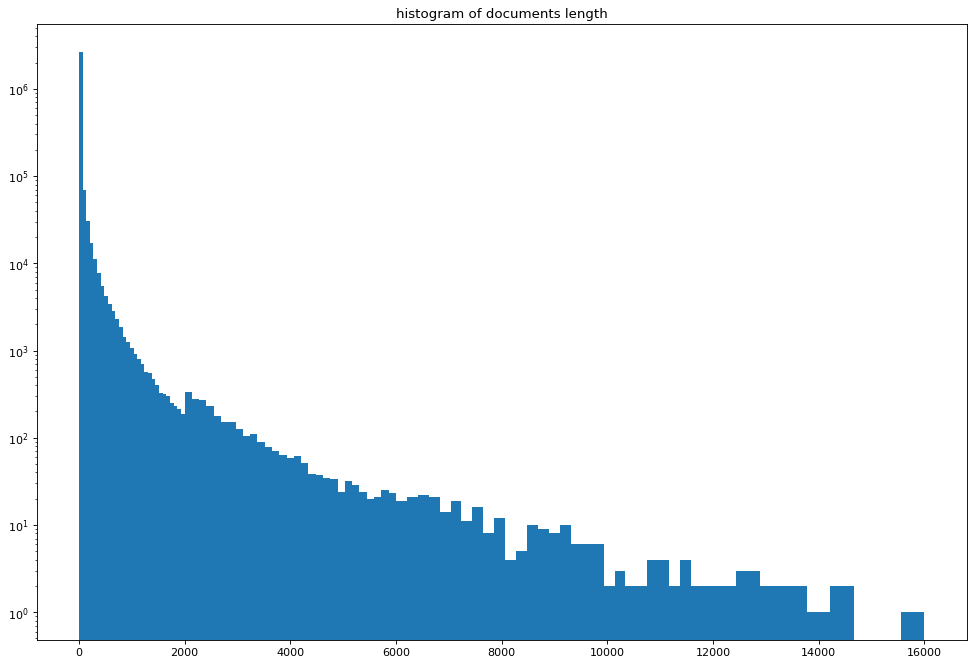

In [46]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 10), dpi=80)

plt.title("histogram of documents length")
_  =plt.hist(documents_length , bins =list(np.linspace(0 , 2000 , 30)) + list(np.linspace(2000 , 6000 , 30)) +
                                         list(np.linspace(6000 , 12000 , 30)) + list(np.linspace(12000 , 16000 , 10)),
            log  =True )

In [43]:
documents_length_KV_sorted[0:5]

[{'title': 'نادرشاه',
  'url': 'https://fa.wikipedia.org/wiki?curid=10787',
  'num_words': 15807},
 {'title': 'نبرد اسمولنسک',
  'url': 'https://fa.wikipedia.org/wiki?curid=2322946',
  'num_words': 14613},
 {'title': 'ایران',
  'url': 'https://fa.wikipedia.org/wiki?curid=163930',
  'num_words': 14417},
 {'title': 'نبرد مسکو',
  'url': 'https://fa.wikipedia.org/wiki?curid=1501875',
  'num_words': 13993},
 {'title': 'حافظ',
  'url': 'https://fa.wikipedia.org/wiki?curid=44114',
  'num_words': 13724}]

## 4)

In [181]:

# topic_words_persian = ['تاریخ' ,  'سیاست' , 'پزشکی' , 'قانون' , 'اقتصاد' , 'مهندسی']
topic_words_english = ['history', 'politics', 'medicine', 'law', 'economics', 'engineering']

topic_words_b = sc.broadcast(topic_words_english)



topic_counters_kv = indexed_article_words_rdd.reduceByKey(lambda x,y:x).map(lambda x:(x[0][0] , 1))\
    .filter(lambda x:x[0].lower() in topic_words_english).reduceByKey(lambda x,y:x+y).collect()

In [182]:
print("num_articles : " , num_articles)
topic_counters_kv

num_articles :  2795590


[('Medicine', 60),
 ('Politics', 28),
 ('LAW', 3),
 ('law', 39),
 ('history', 35),
 ('HIStory', 2),
 ('Engineering', 112),
 ('Law', 96),
 ('Economics', 37),
 ('HISTORY', 2),
 ('economics', 12),
 ('medicine', 15),
 ('History', 160),
 ('politics', 8),
 ('engineering', 23)]

In [183]:
for topic_word in topic_counters_kv:
    print(topic_word[0], ' is : ' , topic_word[1]*100/num_articles , "%" )

Medicine  is :  0.0021462374668674592 %
Politics  is :  0.0010015774845381475 %
LAW  is :  0.00010731187334337295 %
law  is :  0.0013950543534638484 %
history  is :  0.0012519718556726846 %
HIStory  is :  7.154124889558197e-05 %
Engineering  is :  0.00400630993815259 %
Law  is :  0.0034339799469879344 %
Economics  is :  0.0013235131045682665 %
HISTORY  is :  7.154124889558197e-05 %
economics  is :  0.0004292474933734918 %
medicine  is :  0.0005365593667168648 %
History  is :  0.005723299911646558 %
politics  is :  0.0002861649955823279 %
engineering  is :  0.0008227243622991926 %


# Section 4: TF-IDF + Searching (55 Points)

In [18]:
import math 

#### tf

In [72]:

word_tf_rdd = indexed_article_words_rdd.reduceByKey(lambda x,y:x+y)

# input:
## [(key = ('wordk' , doc_index) , value = 1 ) ,(key = ('wordk' , doc_index) , value = 1 )...]
# ouput :
## [(key = ('wordk' , doc_index) , value = tf ) , (key = ('wordk' , doc_index) , value = tf )...]



In [73]:
word_tf_reordered_KV_rdd = word_tf_rdd.map(lambda x: (x[0][0] , (x[0][1], x[1]))) 
## (key = 'wordk' , value = (doc_index , tf))

In [68]:
word_tf_reordered_KV_rdd.take(3)

[('تکواژها', (23, 2)), ('منبع', (32, 1)), ('کشید', (34, 1))]

#### df & idf

In [74]:
word_df_rdd = word_tf_rdd.map(lambda x:(x[0][0] , 1)).reduceByKey(lambda x,y: x+y)

# ouput 1:
## (key = 'wordk'  , value = 1 )
# ouput 2:
## (key = 'wordk' ,  value = df )

word_idf_rdd = word_df_rdd.mapValues(lambda x:math.log((1+num_articles_b.value)/(1+x)))

# ouput :
## [(key = wordk , value = idf ) , (key = wordk , value = idf )....]

#### join tf tuples & idf tuples

In [75]:
joined_words_and_docs_tf_idf_rdd = word_tf_reordered_KV_rdd.join(word_idf_rdd)
## (key = 'word' , value = ((doc_index , tf) , idf)))

tfidf_rdd = joined_words_and_docs_tf_idf_rdd.map(lambda x: (x[1][0][0] ,(x[0], x[1][0][1]*x[1][1])))
## (key = doc_index , value = ('word' , tfidf))

indexed_tfidf_rdd = tfidf_rdd.groupByKey().mapValues(lambda x:dict(list(x)))

# ouput 1:
## (key = doc_index , value = iterable(('word1' , tfidf1),('word2' , tfidf2), ....) )
# ouput 2:
## (key = doc_index , value = {'word1':tfidf1 , ...})

#### Joining tfidf with the cleaned dic

In [76]:


joined_articles_and_tfidf_rdd = indexed_article_cleaned_rdd.join(indexed_tfidf_rdd)
# output :
## (key = doc_index , value = (cleaned_dic ,{'word1':tfidf1 , ...} )

articles_tf_idf_vectors = joined_articles_and_tfidf_rdd.map(lambda x:{'title': x[1][0]['title'] , 'url':x[1][0]['url'] ,'text':x[1][0]['text'] ,'vector':x[1][1]})

# output :
## articles_tf_idf_vectors = [ cleaned_dic1 with added 'vector' list ,cleaned_dic2 with added 'vector' list ,..]

In [80]:

articles_tf_idf_vectors.take(2)

[{'title': 'صفحه اصلی',
  'url': 'https://fa.wikipedia.org/wiki?curid=2',
  'text': 'lttemplatestyles srcصفحه اصلیstylescssgt امروز میلادی برابر هجری خورشیدی UTC – NOEDITSECTION',
  'vector': {'خورشیدی': 5.672266446522762,
   'srcصفحه': 14.150406910675299,
   'میلادی': 3.494866679668701,
   'lttemplatestyles': 10.199163192093872,
   'اصلیstylescssgt': 14.150406910675299,
   'برابر': 4.082210328662131,
   '–': 3.8033078316745117,
   'هجری': 5.657199082009573,
   'NOEDITSECTION': 14.150406910675299,
   'UTC': 9.496446560517775,
   'امروز': 5.8628784875635365}},
 {'title': 'چیماماندا انگزی آدیچی',
  'url': 'https://fa.wikipedia.org/wiki?curid=149294',
  'text': 'چیماماندا انگزی ادیچی نویسنده نیجریایی استزندگیاو سال ۱۹۷۷ نیجریه دنیا آمد رمان نیمی یک خورشید زرد سال ۲۰۰۷ جایزه ادبیات داستانی زنان برد',
  'vector': {'زنان': 5.141081737940325,
   'استزندگیاو': 10.116166272522904,
   '۲۰۰۷': 5.545935711152001,
   'ادبیات': 5.668737275328108,
   'جایزه': 4.8164339782538415,
   'نیجریه': 7.578823

As we can see, TF-IDF can be a very handy metric for determining how important a term is in a document.

In [ ]:
# word_df_rdd = #TODO: calculate document frequncy for each word
# articles_tf_idf_vectors = #TODO: add `vector` key to articles_cleaned_rdd dictionary with the tf_idf dictionary

## Searching
In this section you should find articles that are about the topics mentioned in the last part of the third section.
Report the percentage of articles that are about the mentioned topics, for example, report what percentage of the articles were about history?
For each topic, report two of the most relevant articles along with the title and the url.
Check this part in **theory** before practical implementation (Hint: Use the concept of tf-idf).
All innovative solutions are also welcome. Compare the obtained results with the third part.

In [81]:
def search_query(word):
    query_word_rdd = sc.parallelize([(word,1)])

    results_rdd = tfidf_rdd.map(lambda x:(x[1][0],(x[0], x[1][1]))).join(query_word_rdd).map(lambda x:(x[1][0][0] ,(x[0] , x[1][0][1]*x[1][1])))\
                .join(indexed_article_cleaned_rdd)
    
    results = results_rdd.collect()
    print("number of results for '{}' : {}".format(word,len(results)))
    
    results = sorted(results , key = lambda x: x[1][0][1])
    print("two most relevant results : \n" ,results[0:2])

    return results
    # input
    ## (key = doc_index , value = ('word' , tfidf))
    # output 1
    ## (key = 'word' , value = (doc_index , tfidf ))
    # output 2
    ## (key = 'word' , value = ((doc_index , tfidf),1))
    # output 3
    ## (key = doc_index , value = ('word' , cosine_similarity))
    # output 4
    ## (key = doc_index , value = (('word' , cosine_similarity) , article_dict)



In [82]:
law_infomation =search_query("law")

number of results for 'law' : 39
two most relevant results : 
 [(928241, (('law', 11.154674637121309), {'url': 'https://fa.wikipedia.org/wiki?curid=6116004', 'title': 'قانون توان تیلور', 'text': 'قانون توان تیلور قانون تیلور Taylors law یک قانون تجربی بومشناسی واریانس تعداد افراد یک گونه واحد سطح زیستگاه میانگین متناظر یک رابطه قانون توان مرتبط نام نام بومشناس اولین بار سال ۱۹۶۱ پیشنهاد لیونل تیلور ۱۹۲۴–۲۰۰۷ گرفته نام اصلی تیلور رابطه قانون میانگین نام قانون تیلور ساوت وود سال ۱۹۶۶ ابداع'})), (722057, (('law', 11.154674637121309), {'url': 'https://fa.wikipedia.org/wiki?curid=5271852', 'title': 'امکیووی', 'text': 'امکیووی MQV یک پیشنویس معتبر طرحهای DIFFLE HELMAN پایه توافقنامههای کلیدی میباشدمانند طرحهای معتبر diffie hellmanmqv برابر یک مهاجم فعال محافظا ایجاد نویس میتواند طوری اصلاح شودکه یک گروه قراردادی محدود بخصوص گروههای منحنیهای بیضوی کارکند نام ecmqv شناخته میشودmqvدر ابتدا Minghua Qu سال ۱۹۹۵ مطرح ودر سال ۱۹۹۸ law Solinaasبا وجود انواع یک بار بار سه بار تأیید اصلاح شدMQV استاند

In [83]:
engineering_infomation =search_query("engineering")

number of results for 'engineering' : 23
two most relevant results : 
 [(151, (('engineering', 11.665500260887299), {'url': 'https://fa.wikipedia.org/wiki?curid=1443', 'title': 'باغبانی', 'text': 'باغبانی دانش فن بررسی پژوهش میوهشناسی سبزیشناسی گلشناسی فضای سبز پارکها بوستانها محیط زیست محصولات باغبانی صنایع غذایی استباغبانی عبارت علم کاشت وپرورش گیاهان زینتی گیاهان دارویی ودرختان میوه طراحی فضای سبز فضای سبز همان Landscape engineering شاخهای علوم باغبانی کارشناسی ارشد باغبانی ارائه میگردد پیشرفت شهرنشینی توجه کاشت گیاهان زینتی شهرها عنوان زیبایی ضروری نظر میرسدباغبانی فعالیت هنر پیشه رویاندن گیاهان باغبانی پیرامون خانه مسکن افراد محلی نام باغ باغچه صورت میگیرد باغها بیشتر چسبیده نزدیکی مناطق مسکونی جای دارد پیرامون شهرها روستاها باغچهها حیاط خانهها کنار خیابانها ساخته میشوند ولی ممکن گاه بالای پشت بامها پیشسراها ایوانکها گلشنهها فلاورباکسها نورخانهها پاسیوها ساخته شوندوسایل باغبانیبه طور کلی وسایل باغبانی صورت حرفه ای آماتور موجود باغبانی دستکش بیل بیلچه شن کش آب پاش قیچی هرس فرقون شو

In [84]:
politics_infomation =search_query("politics")

number of results for 'politics' : 8
two most relevant results : 
 [(188064, (('politics', 12.646329513899024), {'url': 'https://fa.wikipedia.org/wiki?curid=1100409', 'title': 'کلکبازیها و شایعهها در ایران', 'text': 'شایعهها شوخیهای فریبآمیز دارای تاریخچهای ایران هستندشایعه دیده شدن تصویر سید روحالله خمینی ماه یک مهمترین آنهاست حافظه تاریخی ایرانیان ثبت چند بار انتشار شایعات مرگ سید علی خامنهای رهبر ایران شایعههای سیاسی قابل توجه موارد تاریخی سال ۱۲۶۴ قمری اشاره دستور امیرکبیر برنامه واکسیناسیون آبلهکوبی کودکان ایرانی میشد مردم ناآگاهی باور خرافات آبلهکوبی نمیدادند دلایلشان فالگیرها دعانویسها شایعه کرده بودند آبلهکوبی سبب جن خون وارد بچه جنزده شوددر نخستین سالهای پیروزی انقلاب ۱۳۵۷ ایران اینکه محمدرضا پهلوی شاه سابق ایران خارج کشور درگذشت شایعهای مبنی زنده بودن آماده شدنش دستگیری مجدد قدرت شکل گرفت چندان عمومی نشد صدا سیمای جمهوری اسلامی ایران مجموعهای تلویزیونی نام شاه دزد ساخته پخش مسئولان جمهوری اسلامی ایران پخش سریال کنار تمسخر شاه سابق پیام رساندند شایعه توطئهای نهفتهاست رویکرد مو

In [78]:
results_infomation =search_query("medicine")

number of results for 'medicine' : 15
relevant results : 
 [(82605, (('medicine', 12.070965368995463), {'url': 'https://fa.wikipedia.org/wiki?curid=406499', 'title': 'کاربرد فناوری اطلاعات در پزشکی', 'text': 'رشد روزافزون صنایع ارتباطی مخابراتی انفورماتیکی روز دنیا انقلابی جدید مواجه انقلاب فن آوری اطلاعات ارتباطات کلیه بخشهای اقتصادی اجتماعی سیاسی امنیتی کشورها تأثیراتی قابل توجه جای گذاشتهاست توسعه فن آوری بخش پزشکی دنبال تحول عظیمی نظام ارائه خدمات بهداشتی درمانی میباشیم مهمترین حوزههای کاربرد فن آوری اطلاعات حوزه بهداشت درمانی فن آوری اطلاعات روشهای متعددی میتواند حوزه کمک نماید سیستمهای ذخیره اطلاعات بیمار سیستمهای اطلاعات دارویی سیستمهای درمانی جراحی سیستمهای پیگیری درمان سیستمهای درمان راه دور سیستمهای راهبری پرستار رباتهای جراح سیستمهای پذیرش بیمار بسیاری پرده طراحی تمام اینها یک هدف مشترک وجود دارد تسهیل کار درمان سیستمها بیمار کمترین زمان بهترین خدمات دریافت پزشک تمام وقت جای دنیا بخواهد بیماران دسترسی دارد اطلاعات بیماران همه جا بهطور کامل دسترس دسترسی همگانی اطلاعات پزشکی ب

In [79]:
results_infomation = search_query("history")


number of results for 'history' : 35
relevant results : 
 [(660049, (('history', 11.260035152779135), {'url': 'https://fa.wikipedia.org/wiki?curid=4860306', 'title': 'شبهاندام مغزی', 'text': 'شبهاندام مغزی ارگانویید مغزی نوعی اندام مینیاتور مصنوعی آزمایشگاه تولید شبیه مغز ارگانوییدهای مغزی طریق کشت سلولهای بنیادی پرتوان بیورآکتورهای چرخشی گذشت چند ماه ایجاد میشوند مغز انسان یک سیستم بسیار پیچیده بافتهای هتروژن شامل انواع مختلفی یاختههای عصبی پیچیدگی مطالعه مغز نحوه کار سخت مخصوصا هنگامی موضوع بیماریهای نورودژنراتیو مرتبط هدف ایجاد مدلهای نورولوژیک in vitro مطالعه بیماریها یک فضای سادهتر قابل تغییر بدون محدودیتهای شرایط in vivo مخصوصا هنگام کار انسان تفاوتهای میان فیزیولوژی انسان سایر مدلهای پستاندار امکان مطالعه بیماریهای نورولوژیک محدود شبه اندامهای مغزی بافتهای سنتز شدهای حاوی انواع مختلفی یاختههای عصبی همینطور ساختارهای آناتومیکی میباشند شبیه مغز پستانداران شبه اندامهای مغزی بیشترین شباهت لایههای یاختههای عصبی قشر مغز کورتکس شبکه کورویید گفته دارند برخی موارد ساختارهایی شبیه شبکیه م